In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Konfigurasi Awal ---
# Pastikan nama file video dan ekstensinya benar dan berada di folder yang sama
video_path = 'mentahan_video.mp4'
# Nama file untuk video output optical flow
output_video_flow_path = 'video_motogp_with_optical_flow.mp4'

print("Memulai proses...")

# --- Membaca Video Input ---
# Buka objek video menggunakan OpenCV
cap = cv2.VideoCapture(video_path)

# Periksa apakah video berhasil dibuka
if not cap.isOpened():
    print(f"Error: Tidak dapat membuka video di {video_path}. Pastikan file ada dan terbaca.")
    exit()

# Dapatkan properti video input (lebar, tinggi, FPS, total frame)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Info Video: Dimensi {frame_width}x{frame_height}, FPS: {fps}, Total Frames: {total_frames}")

# --- Menyiapkan Video Output untuk Optical Flow ---
# Lebar output akan dua kali lipat (frame asli + visualisasi flow)
out_width = frame_width * 2
out_height = frame_height

# Buat objek VideoWriter untuk menyimpan video optical flow
# Codec 'mp4v' biasanya berfungsi baik untuk format .mp4
out_flow_video = cv2.VideoWriter(output_video_flow_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (out_width, out_height))

# Periksa apakah VideoWriter berhasil dibuat
if not out_flow_video.isOpened():
    print(f"Error: Tidak dapat membuat video writer untuk {output_video_flow_path}.")
    print("Pastikan codec 'mp4v' tersedia di sistem Anda atau coba 'XVID' untuk .avi.")
    cap.release()
    exit()

print(f"Video optical flow akan disimpan di: {output_video_flow_path}")

# --- Inisialisasi

Memulai proses...
Info Video: Dimensi 1080x1920, FPS: 30, Total Frames: 363
Video optical flow akan disimpan di: video_motogp_with_optical_flow.mp4


In [13]:
# --- Baca Frame Pertama untuk Inisialisasi Optical Flow ---
ret, first_frame = cap.read()
if not ret:
    print("Error: Tidak ada frame pertama yang dapat dibaca.")
    cap.release()
    out_flow_video.release()
    exit()

# Konversi frame pertama ke skala abu-abu
prev_frame_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

# Tulis frame pertama ke video output optical flow
# Karena belum ada gerakan terhitung, panel optical flow akan kita buat hitam
black_panel = np.zeros_like(first_frame) # Membuat panel hitam dengan ukuran yang sama
combined_first_frame = np.hstack((first_frame, black_panel)) # Gabungkan frame asli dengan panel hitam
out_flow_video.write(combined_first_frame) # Tulis ke video output

frame_idx += 1 # Tambah penghitung frame

print(f"Frame 1 diproses dan ditambahkan ke video output. Memulai looping frame...")

print("\n--- Tahap 2: Inisialisasi Frame Pertama Selesai ---\n")

Frame 1 diproses dan ditambahkan ke video output. Memulai looping frame...

--- Tahap 2: Inisialisasi Frame Pertama Selesai ---



In [14]:
# --- Looping untuk Memproses Setiap Frame ---
while True:
    ret, frame_bgr = cap.read() # Baca frame berikutnya
    if not ret:
        break # Keluar dari loop jika tidak ada frame lagi

    # --- Ekstraksi Fitur 1: Histogram Warna RGB ---
    # Pisahkan channel warna B, G, R
    b, g, r = cv2.split(frame_bgr)

    # Hitung histogram mentah untuk setiap channel
    hist_r = cv2.calcHist([r], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([g], [0], None, [256], [0, 256])
    hist_b = cv2.calcHist([b], [0], None, [256], [0, 256])

    # Gabungkan histogram mentah dari ketiga channel dan simpan ke list
    all_raw_histograms.append(np.concatenate((hist_r.flatten(), hist_g.flatten(), hist_b.flatten())))

    # --- Ekstraksi Fitur 2: Optical Flow (Farneback) ---
    # Konversi frame saat ini ke skala abu-abu
    curr_frame_gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

    # Hitung optical flow antara frame sebelumnya dan frame saat ini
    flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, curr_frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # Dapatkan magnitudo (kecepatan) dan sudut (arah) dari vektor flow
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # --- Visualisasi Optical Flow ---
    # Buat citra HSV untuk visualisasi flow
    hsv = np.zeros_like(frame_bgr)
    hsv[..., 1] = 255 # Atur saturasi penuh
    hsv[..., 0] = angle * 180 / np.pi / 2 # Atur Hue berdasarkan sudut (0-179)
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX) # Atur Value berdasarkan magnitudo (0-255)

    # Konversi citra HSV ke format BGR untuk ditampilkan
    rgb_flow_visualization = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # --- Gabungkan Frame Asli dan Visualisasi Optical Flow untuk Video Output ---
    combined_frame_for_video = np.hstack((frame_bgr, rgb_flow_visualization))
    out_flow_video.write(combined_frame_for_video) # Tulis frame gabungan ke video output

    # --- Pembaruan untuk Iterasi Berikutnya ---
    prev_frame_gray = curr_frame_gray # Frame saat ini menjadi frame sebelumnya untuk iterasi berikutnya
    frame_idx += 1 # Tambah penghitung frame

    # Cetak progres setiap 1 detik video (misal, setiap 30 frame jika FPS=30)
    if frame_idx % fps == 0:
        print(f"Memproses frame {frame_idx}/{total_frames}...")

print(f"Selesai memproses {frame_idx -1} frame.") # frame_idx sudah inkremen 1 di awal
print("\n--- Tahap 3: Looping Proses Frame dan Pembuatan Video Selesai ---\n")

Memproses frame 390/363...
Memproses frame 420/363...
Memproses frame 450/363...
Memproses frame 480/363...
Memproses frame 510/363...
Memproses frame 540/363...
Memproses frame 570/363...
Memproses frame 600/363...
Memproses frame 630/363...
Memproses frame 660/363...
Memproses frame 690/363...
Memproses frame 720/363...
Selesai memproses 724 frame.

--- Tahap 3: Looping Proses Frame dan Pembuatan Video Selesai ---



Video optical flow berhasil disimpan sebagai: video_motogp_with_optical_flow.mp4
Dimensi rata-rata histogram warna: (768,)


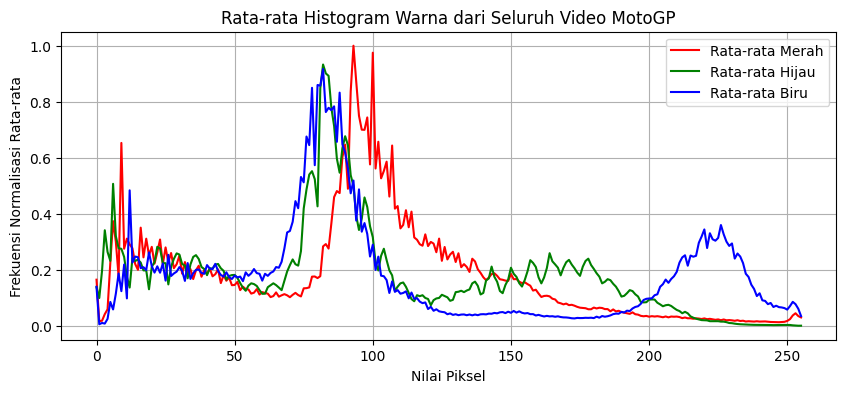


--- Tahap 4: Finalisasi dan Visualisasi Selesai ---


Semua proses selesai. Anda dapat memeriksa file video dan plot histogram yang dihasilkan.


In [15]:
# --- 4.1 Melepaskan Sumber Daya Video ---
cap.release()        # Tutup objek pembaca video
out_flow_video.release() # Tutup objek penulis video

print(f"Video optical flow berhasil disimpan sebagai: {output_video_flow_path}")

# --- 4.2 Perhitungan dan Visualisasi Rata-rata Histogram Warna ---
if all_raw_histograms:
    # Gabungkan semua histogram mentah ke dalam satu NumPy array
    all_raw_histograms_np = np.array(all_raw_histograms)
    # Hitung rata-rata untuk setiap bin histogram di seluruh frame
    average_color_histogram = np.mean(all_raw_histograms_np, axis=0)
    # Normalisasi rata-rata histogram ini agar nilainya antara 0 dan 1 untuk visualisasi
    average_color_histogram_norm = cv2.normalize(average_color_histogram, None, 0, 1, cv2.NORM_MINMAX).flatten()

    print(f"Dimensi rata-rata histogram warna: {average_color_histogram_norm.shape}")

    # Tampilkan plot rata-rata histogram
    plt.figure(figsize=(10, 4))
    plt.plot(average_color_histogram_norm[:256], color='r', label='Rata-rata Merah')
    plt.plot(average_color_histogram_norm[256:512], color='g', label='Rata-rata Hijau')
    plt.plot(average_color_histogram_norm[512:], color='b', label='Rata-rata Biru')
    plt.title('Rata-rata Histogram Warna dari Seluruh Video MotoGP')
    plt.xlabel('Nilai Piksel')
    plt.ylabel('Frekuensi Normalisasi Rata-rata')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Tidak ada frame yang diproses, sehingga rata-rata histogram warna tidak dapat dihitung atau ditampilkan.")

print("\n--- Tahap 4: Finalisasi dan Visualisasi Selesai ---\n")
print("\nSemua proses selesai. Anda dapat memeriksa file video dan plot histogram yang dihasilkan.")